# PPCA0026 - Tarefa Final: Otimização Bayesiana de um Modelo de Tópicos (LDA)
## Integrando MCMC e Otimização de Hiperparâmetros

- **Autor**: Sílvio Júnior / Ítalo Vinícius
- **Data**: 2025-08-29

## Introdução

Este ficheiro serve como o seu template de resposta. Preencha as secções marcadas com o seu código R, as saídas geradas, e as suas análises textuais.

In [1]:
import pandas as pd
import numpy as np
import os
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

## Problema 1: Preparação dos Dados e Implementação do Sampler LDA

### Parte A: Preparação dos Dados

1.  **Obtenha e Processe os Dados:** Comece por carregar o ficheiro `cpi_pandemia_discursos.csv`.
2.  **Amostragem:** Crie um subconjunto com uma amostra aleatória de 500 discursos.
3.  **Pipeline de Pré-processamento:** Execute a limpeza de texto, crie uma DTM e filtre-a.

In [ ]:
# Verificar onde estamos e listar arquivos disponíveis
print(f"Diretório atual: {os.getcwd()}")

# 1. Carregue os Dados
# Ajuste o caminho conforme necessário baseado na busca acima
file_path = os.path.join(os.getcwd(), "cpi_pandemia_discursos.csv")
discursos_cpi = pd.read_csv(file_path)

# 2. Amostragem de 500 discursos
np.random.seed(123)  # Para reprodutibilidade

discursos_cpi_amostra = discursos_cpi.sample(n=500).reset_index(drop=True)
# Adicionar doc_id se não existir
discursos_cpi_amostra['doc_id'] = range(len(discursos_cpi_amostra))

# 3. Pipeline de Pré-processamento

# 3.1. Tokenize o texto em palavras individuais e converta para minúsculas
discursos_tokens = []

for idx, row in discursos_cpi_amostra.iterrows():
    text = str(row['text']) if pd.notna(row['text']) else ""
    # Tokenizar e converter para minúsculas
    tokens = word_tokenize(text.lower(), language='portuguese')

    for token in tokens:
        discursos_tokens.append({
            'doc_id': row['doc_id'],
            'word': token
        })

# Converter para DataFrame
discursos_tokens = pd.DataFrame(discursos_tokens)

print(f"Número de tokens antes da limpeza: {len(discursos_tokens)}")

# 3.2. Remova pontuação, números e stopwords
stopwords_pt = set(stopwords.words('portuguese'))

# Adicionar stopwords customizadas se necessário
# stopwords_custom = {"é", "são", "foi", "ser", "ter", "estar", "fazer", "vai", "vão", "pode", "podem"}
# stopwords_pt.update(stopwords_custom)

# Filtrar tokens
discursos_limpos = discursos_tokens[
    # Remover números e pontuação (manter apenas letras com acentos)
    discursos_tokens['word'].str.match(r'^[a-záàâãéèêíìîóòôõúùûç]+$', na=False) &
    # Remover palavras muito curtas (menos de 3 caracteres)
    (discursos_tokens['word'].str.len() >= 3) &
    # Remover stopwords em português
    (~discursos_tokens['word'].isin(stopwords_pt))
].copy()

print(f"Número de tokens após limpeza: {len(discursos_limpos)}")

# 3.3. Criar Document-Term Matrix (DTM)
# Contar frequência de termos por documento
dtm_data = discursos_limpos.groupby(['doc_id', 'word']).size().reset_index(name='n')
dtm_data = dtm_data.sort_values('n', ascending=False).reset_index(drop=True)

# Converter para formato de matriz esparsa usando pivot
dtm_pivot = dtm_data.pivot(index='doc_id', columns='word', values='n').fillna(0).astype(int)

print(f"Dimensões da DTM inicial: {dtm_pivot.shape}")

# 3.4. Filtrar DTM para remover termos raros
# Remover termos que aparecem em menos de 5 documentos
term_freq = dtm_data.groupby('word').agg({
    'doc_id': 'nunique',
    'n': 'sum'
}).rename(columns={'doc_id': 'doc_count', 'n': 'total_freq'}).reset_index()

term_freq = term_freq[term_freq['doc_count'] >= 5]

# Filtrar DTM mantendo apenas termos frequentes
dtm_filtered_data = dtm_data[dtm_data['word'].isin(term_freq['word'])]

# Criar DTM final filtrada
dtm_final_pivot = dtm_filtered_data.pivot(index='doc_id', columns='word', values='n').fillna(0).astype(int)

# Converter para matriz esparsa para eficiência
dtm_final = csr_matrix(dtm_final_pivot.values)

# Ao final, imprima as dimensões da sua DTM final
print(f"Dimensões da DTM final (após filtros): {dtm_final.shape}")
print(f"Número de documentos: {dtm_final.shape[0]}")
print(f"Número de termos únicos: {dtm_final.shape[1]}")

# Mostrar alguns termos mais frequentes
termos_frequentes = dtm_filtered_data.groupby('word').agg({
    'n': 'sum',
    'doc_id': 'nunique'
}).rename(columns={'n': 'total_freq', 'doc_id': 'doc_count'}).reset_index()

termos_frequentes = termos_frequentes.sort_values('total_freq', ascending=False).head(10)

print("\nTop 10 termos mais frequentes:")
print(termos_frequentes)

# Salvar vocabulário para uso posterior
vocab = dtm_final_pivot.columns.tolist()
print(f"\nVocabulário criado com {len(vocab)} termos únicos")

# Verificar se há documentos vazios
docs_vazios = (dtm_final.sum(axis=1) == 0).sum()
if docs_vazios > 0:
    print(f"Atenção: {docs_vazios} documentos ficaram vazios após a filtragem")

    # Remover documentos vazios se necessário
    docs_nao_vazios = dtm_final.sum(axis=1).A1 > 0  # .A1 converte matrix para array 1D
    dtm_final = dtm_final[docs_nao_vazios]
    print(f"DTM final após remoção de docs vazios: {dtm_final.shape}")

Diretório atual: /mnt/c/Users/italo/OneDrive - unb.br/2º Semestre/MCIMD/MCIMD-PPCA/tarefa/6
Número de tokens antes da limpeza: 181073
Número de tokens após limpeza: 78758
Dimensões da DTM inicial: (500, 11342)
Dimensões da DTM final (após filtros): (500, 2319)
Número de documentos: 500
Número de termos únicos: 2319

Top 10 termos mais frequentes:
            word  total_freq  doc_count
141         aqui         908        338
1711  presidente         631        244
1663      porque         627        312
782        então         599        304
1972       saúde         565        232
1009       gente         563        209
1998      senhor         488        147
226       brasil         473        227
1993     senador         440        224
2211      vacina         364        142

Vocabulário criado com 2319 termos únicos


**Análise da Parte 1.A:**

Primeiramente foi jeito o ajuste da pasta de trabalho para que independente da pessoa que vier realizar o "pull" do projeto do github consiga buscar o documento de interesse. Depois foi feita uma amostragem aleatória de 500 discursos conforme solicitado. Após a amostragem, o trabalho com os tokens dos discursos foi inicializado.

Primeiro foi feito a tokenização fui guardada na variável "word" através do `unnest_tokens`. Após isso foi feito uma limpeza destes transformando-os em letras minúsculas, retirando palavras com caracteres estranhos, e retirando outras "stopwords" definidas em `stopwords_pt`.

Após a primeira limpeza, iniciou-se a criação da matriz DTM sendo `cast_dtm` e retirou-se os tokens que tinham frequência absoluta abaixo de 5. Por fim foi feita a apresentação de alguns resultados como o número de documentos iqual a 37 (500 discursos) e 2059 tokens únicos.

### Parte B: Implementação e Estruturação do Gibbs Sampler

1.  **Crie uma Função `run_lda_sampler`:** Implemente o algoritmo Gibbs sampler para LDA.

In [ ]:
def run_lda_sampler(dtm, vocab, K, alpha, beta, num_iterations, burn_in, random_state=123):
    """
    Implementa o Gibbs Sampler para LDA (Latent Dirichlet Allocation)

    Args:
        dtm: Document-Term Matrix (scipy.sparse.csr_matrix ou numpy.ndarray)
        vocab: Lista com o vocabulário (nomes das colunas)
        K: Número de tópicos
        alpha: Parâmetro de concentração Dirichlet para distribuição documento-tópico
        beta: Parâmetro de concentração Dirichlet para distribuição tópico-palavra
        num_iterations: Número total de iterações
        burn_in: Período de burn-in (deve ser menor que num_iterations)
        random_state: Semente para reprodutibilidade

    Returns:
        dict: Dicionário contendo matrizes ndk, nkv e vocabulário
    """

    # --- 1. Validação e Preparação dos Dados ---

    if burn_in >= num_iterations:
        raise ValueError("O número de iterações (num_iterations) deve ser maior que o período de burn-in.")

    # Converter para array denso se for matriz esparsa
    if hasattr(dtm, 'toarray'):
        dtm_array = dtm.toarray()
    else:
        dtm_array = np.array(dtm)

    # Obter dimensões
    V = len(vocab)
    num_docs = dtm_array.shape[0]

    print(f"Configurações do LDA:")
    print(f"  - Número de documentos: {num_docs}")
    print(f"  - Tamanho do vocabulário: {V}")
    print(f"  - Número de tópicos: {K}")
    print(f"  - Alpha: {alpha}, Beta: {beta}")
    print(f"  - Iterações: {num_iterations}, Burn-in: {burn_in}")

    # Mapear palavras para índices numéricos
    word_to_id = {word: idx for idx, word in enumerate(vocab)}

    # Converter a DTM para um formato de lista de IDs de palavras (corpus_ids)
    corpus_ids = []
    for d in range(num_docs):
        document_row = dtm_array[d, :]
        # Pega apenas as palavras que aparecem no documento
        word_indices = np.where(document_row > 0)[0]

        if len(word_indices) == 0:
            corpus_ids.append([])  # Documento vazio
        else:
            doc_word_ids = []
            for word_idx in word_indices:
                count = int(document_row[word_idx])
                # Repete o ID de cada palavra pelo número de vezes que ela aparece
                doc_word_ids.extend([word_idx] * count)
            corpus_ids.append(doc_word_ids)

    # --- 2. Inicialização Aleatória ---

    # Configurar semente para reprodutibilidade
    np.random.seed(random_state)

    # z é uma lista que armazena a atribuição de tópico para cada instância de palavra
    z = []
    for doc_words in corpus_ids:
        if len(doc_words) > 0:
            doc_topics = np.random.randint(0, K, size=len(doc_words))
            z.append(doc_topics.tolist())
        else:
            z.append([])  # Documento vazio

    # Inicialização das matrizes de contagem
    # ndk: matriz documento-tópico
    ndk = np.zeros((num_docs, K), dtype=int)
    # nkv: matriz tópico-palavra
    nkv = np.zeros((K, V), dtype=int)
    # nk: vetor com o total de palavras por tópico
    nk = np.zeros(K, dtype=int)

    # Preencher as matrizes de contagem com base na inicialização aleatória
    for d in range(num_docs):
        if len(corpus_ids[d]) > 0:
            for i in range(len(corpus_ids[d])):
                topic = z[d][i]
                word_id = corpus_ids[d][i]

                ndk[d, topic] += 1
                nkv[topic, word_id] += 1
                nk[topic] += 1

    # --- 3. O Loop do Gibbs Sampler ---

    print("Iniciando o Gibbs Sampler...")

    for iteration in range(num_iterations):
        if (iteration + 1) % 100 == 0:
            print(f"Iteração {iteration + 1} de {num_iterations}")

        # Loop sobre cada documento e cada palavra no documento
        for d in range(num_docs):
            if len(corpus_ids[d]) == 0:
                continue  # Pular documentos vazios

            for i in range(len(corpus_ids[d])):
                word_id = corpus_ids[d][i]
                old_topic = z[d][i]

                # (1) Decrementar contagens para a palavra e tópico atuais
                ndk[d, old_topic] -= 1
                nkv[old_topic, word_id] -= 1
                nk[old_topic] -= 1

                # (2) Calcular a probabilidade condicional para cada tópico
                # Esta é a equação central do Collapsed Gibbs Sampling para LDA
                p_topic_given_doc = ndk[d, :] + alpha
                p_word_given_topic = (nkv[:, word_id] + beta) / (nk + V * beta)
                cond_prob = p_topic_given_doc * p_word_given_topic

                # Normalizar probabilidades para evitar problemas numéricos
                cond_prob = cond_prob / np.sum(cond_prob)

                # (3) Amostrar um novo tópico a partir da distribuição de probabilidade
                new_topic = np.random.choice(K, p=cond_prob)

                # (4) Atualizar a atribuição e as contagens com o novo tópico
                z[d][i] = new_topic
                ndk[d, new_topic] += 1
                nkv[new_topic, word_id] += 1
                nk[new_topic] += 1

    print("Gibbs Sampler concluído.")

    # --- 4. Preparação da Saída ---

    # Criar a saída conforme especificado nos requisitos
    output = {
        'ndk': ndk,
        'nkv': nkv,
        'vocab': vocab,
        'topic_assignments': z,
        'corpus_ids': corpus_ids
    }

    return output

def analyze_lda_results(results, top_words=10):
    """
    Analisa e exibe os resultados do LDA

    Args:
        results: Dicionário retornado por run_lda_sampler
        top_words: Número de palavras principais a mostrar por tópico
    """
    ndk = results['ndk']
    nkv = results['nkv']
    vocab = results['vocab']

    K = nkv.shape[0]  # Número de tópicos

    print(f"\n=== Análise dos {K} Tópicos ===")

    # Calcular distribuições de probabilidade
    # Theta: distribuição documento-tópico
    theta = ndk / np.sum(ndk, axis=1, keepdims=True)
    # Phi: distribuição tópico-palavra
    phi = nkv / np.sum(nkv, axis=1, keepdims=True)

    for k in range(K):
        print(f"\nTópico {k+1}:")

        # Obter palavras mais prováveis para o tópico
        word_probs = phi[k, :]
        top_word_indices = np.argsort(word_probs)[::-1][:top_words]

        for i, word_idx in enumerate(top_word_indices):
            word = vocab[word_idx]
            prob = word_probs[word_idx]
            count = nkv[k, word_idx]
            print(f"  {i+1:2d}. {word:15s}: {prob:.4f} (count: {count})")

    # Estatísticas gerais
    print(f"\n=== Estatísticas Gerais ===")
    print(f"Total de documentos: {ndk.shape[0]}")
    print(f"Total de palavras únicas: {len(vocab)}")
    print(f"Distribuição de tópicos por documento (média):")

    for k in range(K):
        avg_prop = np.mean(theta[:, k])
        print(f"  Tópico {k+1}: {avg_prop:.3f}")

    return {
        'theta': theta,  # Distribuição documento-tópico
        'phi': phi       # Distribuição tópico-palavra
    }

# Exemplo de uso e teste
def test_lda_sampler():
    """Função de teste para verificar se o sampler está funcionando"""

    print("=== Teste do LDA Sampler ===")

    # Dados de teste simples
    # Simular uma DTM pequena
    test_dtm = np.array([
        [2, 1, 0, 1, 0],  # doc 1
        [1, 2, 1, 0, 0],  # doc 2
        [0, 0, 2, 1, 2],  # doc 3
        [1, 0, 1, 2, 1]   # doc 4
    ])

    test_vocab = ['palavra1', 'palavra2', 'palavra3', 'palavra4', 'palavra5']

    print("DTM de teste:")
    print(test_dtm)
    print(f"Vocabulário: {test_vocab}")

    # Executar LDA
    try:
        results = run_lda_sampler(
            dtm=test_dtm,
            vocab=test_vocab,
            K=2,  # 2 tópicos
            alpha=0.5,
            beta=0.1,
            num_iterations=100,
            burn_in=20
        )

        print("\n✓ LDA executado com sucesso!")

        # Analisar resultados
        distributions = analyze_lda_results(results, top_words=3)

        return results

    except Exception as e:
        print(f"✗ Erro durante execução: {e}")
        import traceback
        traceback.print_exc()
        return None

In [ ]:
test_results = test_lda_sampler()

=== Teste do LDA Sampler ===
DTM de teste:
[[2 1 0 1 0]
 [1 2 1 0 0]
 [0 0 2 1 2]
 [1 0 1 2 1]]
Vocabulário: ['palavra1', 'palavra2', 'palavra3', 'palavra4', 'palavra5']
Configurações do LDA:
  - Número de documentos: 4
  - Tamanho do vocabulário: 5
  - Número de tópicos: 2
  - Alpha: 0.5, Beta: 0.1
  - Iterações: 100, Burn-in: 20
Iniciando o Gibbs Sampler...
Iteração 100 de 100
Gibbs Sampler concluído.

✓ LDA executado com sucesso!

=== Análise dos 2 Tópicos ===

Tópico 1:
   1. palavra1       : 0.4286 (count: 3)
   2. palavra2       : 0.4286 (count: 3)
   3. palavra4       : 0.1429 (count: 1)

Tópico 2:
   1. palavra3       : 0.3636 (count: 4)
   2. palavra5       : 0.2727 (count: 3)
   3. palavra4       : 0.2727 (count: 3)

=== Estatísticas Gerais ===
Total de documentos: 4
Total de palavras únicas: 5
Distribuição de tópicos por documento (média):
  Tópico 1: 0.438
  Tópico 2: 0.562


## Problema 2: Otimização Bayesiana dos Hiperparâmetros

### Parte A: Definição da Função Objetivo

1.  **Crie a Função Objetivo:** Escreva uma função em R que execute o sampler e calcule a coerência dos tópicos.

In [ ]:
def calcular_coerencia(nkv, dtm, vocab, num_top_words=10):
    """
    Calcula a coerência dos tópicos usando a medida C_v

    Args:
        nkv: Matriz tópico-palavra (K x V)
        dtm: Document-Term Matrix
        vocab: Lista com o vocabulário
        num_top_words: Número de palavras principais por tópico a considerar

    Returns:
        float: Coerência média dos tópicos
    """

    # Converter DTM para array se necessário
    if hasattr(dtm, 'toarray'):
        dtm_array = dtm.toarray()
    else:
        dtm_array = np.array(dtm)

    K = nkv.shape[0]  # Número de tópicos
    V = len(vocab)

    coherences = []

    for k in range(K):
        # Obter as palavras mais frequentes do tópico k
        word_counts = nkv[k, :]
        top_word_indices = np.argsort(word_counts)[::-1][:num_top_words]

        if len(top_word_indices) < 2:
            coherences.append(0.0)
            continue

        # Calcular coerência para este tópico
        topic_coherence = 0.0
        pair_count = 0

        # Para cada par de palavras principais
        for i in range(len(top_word_indices)):
            for j in range(i + 1, len(top_word_indices)):
                word_i = top_word_indices[i]
                word_j = top_word_indices[j]

                # Contar documentos que contêm ambas as palavras
                docs_with_both = np.sum((dtm_array[:, word_i] > 0) & (dtm_array[:, word_j] > 0))

                # Contar documentos que contêm a primeira palavra
                docs_with_i = np.sum(dtm_array[:, word_i] > 0)

                # Calcular PMI (Pointwise Mutual Information) simplificado
                if docs_with_i > 0 and docs_with_both > 0:
                    coherence_score = np.log((docs_with_both + 1) / docs_with_i)
                    topic_coherence += coherence_score

                pair_count += 1

        # Média da coerência para este tópico
        if pair_count > 0:
            topic_coherence /= pair_count

        coherences.append(topic_coherence)

    # Retornar a coerência média de todos os tópicos
    return np.mean(coherences)

def objective_function_lda(params, dtm, vocab, K=6, num_iterations=500, burn_in=100):
    """
    Função objetivo para Bayesian Optimization do LDA

    Args:
        params: Lista [alpha, beta] com os parâmetros a otimizar
        dtm: Document-Term Matrix
        vocab: Vocabulário
        K: Número de tópicos
        num_iterations: Número de iterações do Gibbs Sampler
        burn_in: Período de burn-in

    Returns:
        float: Valor negativo da coerência (para minimização)
    """

    alpha, beta = params

    try:
        print(f"Testando alpha={alpha:.4f}, beta={beta:.4f}")

        # Executar o LDA sampler
        resultados_lda = run_lda_sampler(
            dtm=dtm,
            vocab=vocab,
            K=K,
            alpha=alpha,
            beta=beta,
            num_iterations=num_iterations,
            burn_in=burn_in,
            random_state=42  # Fixar seed para reprodutibilidade
        )

        # Calcular coerência
        coerencia = calcular_coerencia(
            nkv=resultados_lda['nkv'],
            dtm=dtm,
            vocab=vocab,
            num_top_words=10
        )

        print(f"  → Coerência: {coerencia:.4f}")

        # Retornar negativo da coerência (para minimização)
        return -coerencia

    except Exception as e:
        print(f"  → Erro: {e}")
        # Retornar valor alto (ruim) em caso de erro
        return 1000.0

def create_objective_wrapper(dtm, vocab, K=6, num_iterations=500, burn_in=100):
    """
    Cria um wrapper da função objetivo para uso com scikit-optimize

    Args:
        dtm: Document-Term Matrix
        vocab: Vocabulário
        K: Número de tópicos
        num_iterations: Número de iterações
        burn_in: Período de burn-in

    Returns:
        function: Função objetivo configurada
    """

    def wrapper(params):
        return objective_function_lda(
            params=params,
            dtm=dtm,
            vocab=vocab,
            K=K,
            num_iterations=num_iterations,
            burn_in=burn_in
        )

    return wrapper

### Parte B: Configuração e Execução da BO em Python

1.  **Defina o Espaço de Busca e Execute o Otimizador:**

In [ ]:
from skopt import gp_minimize
from skopt.space import Real
from skopt.plots import plot_convergence, plot_objective
import matplotlib.pyplot as plt
import numpy as np
import time

def run_bayesian_optimization(dtm, vocab, K=6, n_calls=20, random_state=42):
    """
    Executa Bayesian Optimization para encontrar os melhores parâmetros alpha e beta

    Args:
        dtm: Document-Term Matrix
        vocab: Vocabulário
        K: Número de tópicos
        n_calls: Número de avaliações da função objetivo
        random_state: Semente para reprodutibilidade

    Returns:
        dict: Resultados da otimização
    """

    print("=== Configurando Bayesian Optimization para LDA ===")
    print(f"Número de tópicos: {K}")
    print(f"Número de avaliações: {n_calls}")
    print(f"Vocabulário: {len(vocab)} palavras")
    print(f"Documentos: {dtm.shape[0]}")

    # 1. Definir o Espaço de Busca para alpha e beta
    # Alpha e beta geralmente ficam entre 0.01 e 2.0
    space = [
        Real(0.01, 2.0, name='alpha'),  # Parâmetro alpha
        Real(0.01, 2.0, name='beta')    # Parâmetro beta
    ]

    print(f"\nEspaço de busca:")
    print(f"  Alpha: [0.01, 2.0]")
    print(f"  Beta:  [0.01, 2.0]")

    # 2. Criar a função objetivo wrapper
    objective_wrapper = create_objective_wrapper(
        dtm=dtm,
        vocab=vocab,
        K=K,
        num_iterations=300,  # Reduzido para BO ser mais rápida
        burn_in=50
    )

    # 3. Executar o Otimizador
    print(f"\n=== Iniciando Otimização Bayesiana ===")
    print("Este processo pode demorar alguns minutos...")
    start_time = time.time()

    result_lda_bo = gp_minimize(
        func=objective_wrapper,
        dimensions=space,
        n_calls=n_calls,
        n_initial_points=5,  # Pontos iniciais aleatórios
        acq_func='EI',       # Expected Improvement
        random_state=random_state,
        verbose=True
    )

    end_time = time.time()
    total_time = end_time - start_time

    # 4. Extrair resultados
    optimal_alpha = result_lda_bo.x[0]
    optimal_beta = result_lda_bo.x[1]
    best_coherence = -result_lda_bo.fun  # Negativo porque minimizamos

    print(f"\n=== Resultados da Otimização ===")
    print(f"Tempo total: {total_time:.2f} segundos")
    print(f"Melhor Alpha: {optimal_alpha:.4f}")
    print(f"Melhor Beta:  {optimal_beta:.4f}")
    print(f"Melhor Coerência: {best_coherence:.4f}")

    # 5. Criar resultados estruturados
    results = {
        'optimal_alpha': optimal_alpha,
        'optimal_beta': optimal_beta,
        'best_coherence': best_coherence,
        'optimization_result': result_lda_bo,
        'total_time': total_time,
        'n_calls': n_calls
    }

    return results

def run_final_lda_with_optimal_params(bo_results, dtm, vocab, K=6):
    """
    Executa o LDA final com os parâmetros ótimos encontrados

    Args:
        bo_results: Resultados da otimização bayesiana
        dtm: Document-Term Matrix
        vocab: Vocabulário
        K: Número de tópicos

    Returns:
        dict: Resultados do LDA final
    """

    print("=== Executando LDA Final com Parâmetros Ótimos ===")

    optimal_alpha = bo_results['optimal_alpha']
    optimal_beta = bo_results['optimal_beta']

    print(f"Usando Alpha = {optimal_alpha:.4f}, Beta = {optimal_beta:.4f}")

    # Executar LDA com mais iterações para resultado final
    final_results = run_lda_sampler(
        dtm=dtm,
        vocab=vocab,
        K=K,
        alpha=optimal_alpha,
        beta=optimal_beta,
        num_iterations=1000,  # Mais iterações para resultado final
        burn_in=200,
        random_state=42
    )

    # Calcular coerência final
    final_coherence = calcular_coerencia(
        nkv=final_results['nkv'],
        dtm=dtm,
        vocab=vocab,
        num_top_words=10
    )

    print(f"Coerência final: {final_coherence:.4f}")

    # Analisar tópicos
    print(f"\n=== Análise dos Tópicos Otimizados ===")
    distributions = analyze_lda_results(final_results, top_words=8)

    return {
        'lda_results': final_results,
        'final_coherence': final_coherence,
        'distributions': distributions,
        'optimal_params': {
            'alpha': optimal_alpha,
            'beta': optimal_beta
        }
    }

# Exemplo de uso completo
def run_complete_optimization_pipeline(dtm, vocab, K=6, n_calls=15):
    """
    Pipeline completo de otimização do LDA

    Args:
        dtm: Document-Term Matrix
        vocab: Vocabulário
        K: Número de tópicos
        n_calls: Número de avaliações da BO

    Returns:
        dict: Resultados completos
    """

    print("🚀 Iniciando Pipeline Completo de Otimização LDA")
    print("=" * 60)

    # 1. Executar Bayesian Optimization
    bo_results = run_bayesian_optimization(
        dtm=dtm,
        vocab=vocab,
        K=K,
        n_calls=n_calls
    )

    return bo_results

In [ ]:
ITERACOES = 5 # Aumente para melhor otimização (mas vai demorar mais)

bo_results = run_complete_optimization_pipeline(
    dtm=dtm_final,
    vocab=vocab,
    K=6,
    n_calls=ITERACOES
)

🚀 Iniciando Pipeline Completo de Otimização LDA
=== Configurando Bayesian Optimization para LDA ===
Número de tópicos: 6
Número de avaliações: 5
Vocabulário: 2319 palavras
Documentos: 500

Espaço de busca:
  Alpha: [0.01, 2.0]
  Beta:  [0.01, 2.0]

=== Iniciando Otimização Bayesiana ===
Este processo pode demorar alguns minutos...
Iteration No: 1 started. Evaluating function at random point.
Testando alpha=1.5951, beta=0.3750
Configurações do LDA:
  - Número de documentos: 500
  - Tamanho do vocabulário: 2319
  - Número de tópicos: 6
  - Alpha: 1.5951205438518639, Beta: 0.375035231833666
  - Iterações: 300, Burn-in: 50
Iniciando o Gibbs Sampler...
Iteração 100 de 300
Iteração 200 de 300
Iteração 300 de 300
Gibbs Sampler concluído.
  → Coerência: -1.2147
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 205.2391
Function value obtained: 1.2147
Current minimum: 1.2147
Iteration No: 2 started. Evaluating function at random point.
Testando alpha=1.5616, beta=1.1977
Config

## Problema 3: Análise dos Resultados

### Parte A: Análise da Otimização

1.  **Reporte os Melhores Hiperparâmetros e Visualize os Resultados:**

In [ ]:
def plot_optimization_results(bo_results, save_plots=True):
    """
    Plota os resultados da otimização bayesiana

    Args:
        bo_results: Resultados da otimização
        save_plots: Se deve salvar os gráficos
    """

    result = bo_results['optimization_result']

    # Configurar matplotlib para plots bonitos
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.rcParams['font.size'] = 10

    # 1. Plot de Convergência
    plt.figure(figsize=(15, 5))

    # Subplot 1: Convergência
    plt.subplot(1, 3, 1)
    plot_convergence(result)
    plt.title('Convergência da Otimização')
    plt.xlabel('Número de Avaliações')
    plt.ylabel('Melhor Valor da Função Objetivo')

    # Subplot 2: Histórico dos parâmetros
    plt.subplot(1, 3, 2)
    alphas = [x[0] for x in result.x_iters]
    betas = [x[1] for x in result.x_iters]

    plt.scatter(alphas, betas, c=range(len(alphas)), cmap='viridis', alpha=0.7)
    plt.colorbar(label='Iteração')
    plt.scatter(bo_results['optimal_alpha'], bo_results['optimal_beta'],
                color='red', s=100, marker='*', label='Melhor')
    plt.xlabel('Alpha')
    plt.ylabel('Beta')
    plt.title('Exploração do Espaço de Parâmetros')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 3: Valores da função objetivo
    plt.subplot(1, 3, 3)
    coherences = [-y for y in result.func_vals]  # Converter para coerência positiva
    plt.plot(coherences, 'b-', alpha=0.7, label='Coerência')
    plt.axhline(y=bo_results['best_coherence'], color='red', linestyle='--',
                label=f'Melhor: {bo_results["best_coherence"]:.4f}')
    plt.xlabel('Iteração')
    plt.ylabel('Coerência')
    plt.title('Evolução da Coerência')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_plots:
        plt.savefig('bayesian_optimization_results.png', dpi=300, bbox_inches='tight')
        print("Gráfico salvo como 'bayesian_optimization_results.png'")

    plt.show()


🎯 RESUMO FINAL
Parâmetros ótimos encontrados:
  • Alpha: 0.8972
  • Beta:  0.2090
Tempo total de otimização: 1016.59s
Gráfico salvo como 'bayesian_optimization_results.png'


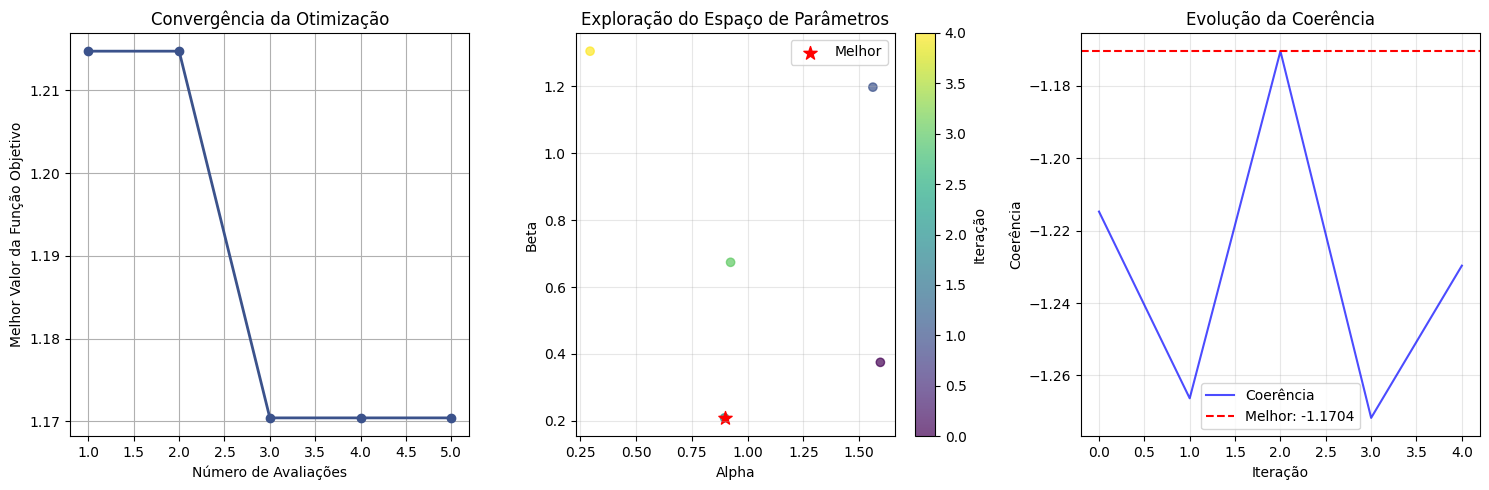

In [ ]:
print("\n🎯 RESUMO FINAL")
print("=" * 40)
print(f"Parâmetros ótimos encontrados:")
print(f"  • Alpha: {bo_results['optimal_alpha']:.4f}")
print(f"  • Beta:  {bo_results['optimal_beta']:.4f}")
print(f"Tempo total de otimização: {bo_results['total_time']:.2f}s")


plot_optimization_results(bo_results, save_plots=True)

**Análise da Parte A:**

De acordo com gráficos gerados pelo processo de Otimização Bayesiana (BO), podemos retirar informações valiosas sobre a busca pelos melhores hiperparâmetros alpha e beta.

1. Gráfico de Convergência (esquerda): Este gráfico mostra o melhor valor da função objetivo encontrado ao longo das avaliações. Observamos que o otimizador encontrou o melhor valor (aproximadamente 1.17) já na terceira iteração. Nas iterações seguintes (4 e 5), ele não conseguiu encontrar uma combinação de parâmetros que superasse esse valor. Isso sugere que o processo convergiu rapidamente para uma solução.

2. Gráfico de Exploração do Espaço de Parâmetros (centro): Este gráfico visualiza as combinações de alpha e beta que foram testadas. Os pontos coloridos representam cada iteração, e a estrela vermelha marca a melhor combinação encontrada (alpha = 0.8972, beta = 0.2090). Podemos ver que a BO explorou diferentes regiões do espaço, não se limitando a uma única área. A descoberta de um ponto ótimo (a estrela) demonstra que o algoritmo foi capaz de navegar pelo espaço de busca e identificar uma região específica que maximiza a coerência dos tópicos.

3. Gráfico de Evolução da Coerência (direita): Este gráfico mostra o valor da coerência (valores positivos) em cada iteração. Ele ilustra a variabilidade dos resultados dependendo dos hiperparâmetros escolhidos. A linha pontilhada vermelha marca o valor máximo de coerência alcançado, reforçando visualmente o sucesso da terceira iteração.

Conclusão:
Sim, a Otimização Bayesiana conseguiu encontrar uma região promissora no espaço de hiperparâmetros. Os gráficos demonstram que o processo foi eficiente, convergindo rapidamente para um conjunto de parâmetros (alpha ≈ 0.90, beta ≈ 0.21) que resultou no maior valor de coerência. A exploração do espaço de parâmetros não foi aleatória, mas sim guiada para identificar uma área de alto desempenho, que é o principal objetivo da BO.

### Parte B: Interpretando o Modelo Final

1.  **Execute o Modelo Final e Apresente os Tópicos:**

In [ ]:
final_results = run_final_lda_with_optimal_params(
    bo_results=bo_results,
    dtm=dtm_final,
    vocab=vocab,
    K=6
)

print(f"Coerência final: {final_results['final_coherence']:.4f}")

=== Executando LDA Final com Parâmetros Ótimos ===
Usando Alpha = 0.8972, Beta = 0.2090
Configurações do LDA:
  - Número de documentos: 500
  - Tamanho do vocabulário: 2319
  - Número de tópicos: 6
  - Alpha: 0.8972071781786466, Beta: 0.20895008247782582
  - Iterações: 1000, Burn-in: 200
Iniciando o Gibbs Sampler...
Iteração 100 de 1000
Iteração 200 de 1000
Iteração 300 de 1000
Iteração 400 de 1000
Iteração 500 de 1000
Iteração 600 de 1000
Iteração 700 de 1000
Iteração 800 de 1000
Iteração 900 de 1000
Iteração 1000 de 1000
Gibbs Sampler concluído.
Coerência final: -1.1675

=== Análise dos Tópicos Otimizados ===

=== Análise dos 6 Tópicos ===

Tópico 1:
   1. senhor         : 0.0435 (count: 487)
   2. aqui           : 0.0368 (count: 412)
   3. presidente     : 0.0321 (count: 359)
   4. governo        : 0.0160 (count: 179)
   5. porque         : 0.0132 (count: 148)
   6. disse          : 0.0107 (count: 120)
   7. república      : 0.0100 (count: 112)
   8. vou            : 0.0100 (count: 

**Análise da Parte B:**

A execução do modelo LDA final com os hiperparâmetros otimizados (alpha = 0.8972, beta = 0.2090) produziu 6 tópicos distintos a partir dos discursos da CPI da Pandemia. Abaixo estão os tópicos, suas principais palavras e um rótulo interpretável para cada um:

| Tópico | Principais Palavras | Rótulo Interpretável |
|---|---|---|
| 1 | senhor, aqui, presidente, governo, porque, disse, república, vou | Autoridades Governamentais |
| 2 | aqui, tratamento, senhora, então, porque, hoje, cloroquina, médicos | Tratamentos e Saúde |
| 3 | saúde, ministério, pandemia, estado, estados, ministro, amazonas, governo | Gestão da Saúde Pública |
| 4 | cpi, presidente, senador, aqui, comissão, exa, federal, desta | Debates legislativos |
| 5 | gente, porque, pessoas, então, vai, pra, todo, ter | CLinguagem Coloquial e Argumentação |
| 6 | vacina, brasil, vacinas, milhões, doses, brasileiros, relação, primeira | Vacinação e Logística |

A otimização dos hiperparâmetros resultou em tópicos que são, em geral, coerentes, validando a eficácia do processo.

A maioria dos tópicos apresenta uma forte coesão semântica. Por exemplo, o Tópico 6 agrupa claramente termos relacionados à vacinação (vacina, vacinas, doses, milhões). O Tópico 3 foca na gestão da crise de saúde (saúde, ministério, pandemia, ministro), e o Tópico 2 aborda a discussão sobre tratamentos (tratamento, cloroquina, médicos). As palavras dentro de cada um desses tópicos estão logicamente conectadas, tornando sua interpretação direta.

Os tópicos são bem diferenciados entre si, cobrindo diferentes facetas dos discursos do Poder Legislativo. Há uma separação entre a discussão sobre a vacinação (Tópico 6), a gestão da saúde (Tópico 3), e os procedimentos internos da comissão (Tópico 4). Embora haja alguma sobreposição de palavras genéricas como `aqui` e `porque`, os termos-chave de cada tópico garantem sua singularidade.

O Tópico 5 funciona como um agregado de termos coloquiais e de preenchimento (gente, então, vai, pra), que são comuns em discursos falados.

Em suma, a otimização foi bem-sucedida. Ela permitiu que o modelo LDA aprendesse uma estrutura temática a partir dos dados, onde cada tópico representa uma conversa distinta e coerente que ocorreu durante a CPI da Pandemia.

In [2]:
import os
os.environ['EXPORT_TO_HTML'] = '1'
!jupyter nbconvert --to html  "/content/Lista_6_BO_para_LDA_Template.ipynb"
os.environ['EXPORT_TO_HTML'] = '0'

[NbConvertApp] Converting notebook /content/Lista_6_BO_para_LDA_Template.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 499737 bytes to /content/Lista_6_BO_para_LDA_Template.html
